# PV254 Recommender Systems
## News reccomendation

For this consultation, you should have:

- problem formulation, usage, hypothetical business model, ...
- specific data with some basic analysis (value distributions etc)
- specific proposal for algorithms that you want to implement
- implementation of some naive baseline
- basic idea of evaluation approach

### Problem formulation & usage 
Application - recommending news articles with UI

#### Where will the recommendations happen
1. User will land on a Home page, where popular articles will be recommended
2. While on an article page, the User will see recommended articles based on the current article and other aspects (popular, category, what he likes, ...)
3. User could choose what categories he likes most. E.g. sports, politcs, etc. (could be nice for cold-start problem)

### Bussines model
The page could generate revenue through clicks, ads, sponsored content, donations, etc.
1. Own portal
    - all articles are made by 'our' news portal
    - revenue is made through ads and subscriptions
2. MSN like portal (reccomending articles of other news portals)
    - mix own 'own' articles and articles of popular news portals (DW, iDnes, Denník N, ...)
    - revenue is made thorugh ads and clicks from our portal to the given news portal (PPC)

### The Dataset
We are using the <a href="https://www.kaggle.com/datasets/arashnic/mind-news-dataset/data">MIND</a> dataset collected from the Microsoft News website. More specificially we will be working with the **Mind-small** version with data from 50k users.\
The dataset structure is explained <a href="https://github.com/msnews/msnews.github.io/blob/master/assets/doc/introduction.md">here</a>.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import matplotlib_inline


In [2]:
# run python -m nbconvert --to html --no-input .\project.ipynb
# to create the markdown html without code snippets

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')
pio.renderers.default='notebook'

data = pd.read_csv('../dataset/news.tsv', header=None, sep='\t', usecols=[0, 1, 2, 3, 4])

data.columns = ['News_ID',
                "Category",
                "SubCategory",
                "Title",
                "Abstract"]

# Data Preprocessing
old_len = len(data)
data.drop_duplicates(subset=['Title'],inplace=True)
print('The number of dropped duplicate article Titles:', old_len - len(data))
data_articles = data
number_of_articles = len(data)
unique_categories = data['Category'].nunique()
unique_subcategories = data['SubCategory'].nunique()

The number of dropped duplicate article Titles: 848


In [3]:
data_users = pd.read_csv('../dataset/behaviors.tsv', header=None, sep='\t', usecols=[0, 1])

data_users.columns = ['ID', "User_ID"]

no_of_behaviors = len(data_users)
no_of_users = data_users['User_ID'].nunique()

In [4]:
# Calculate the length of titles
title_word_counts = data['Title'].apply(lambda x: len(x.split()))
avg_title_words = np.average(title_word_counts)
title_lengths = data['Title'].apply(len)
avg_title_len = np.average(title_lengths)

data.dropna(inplace=True)
abstract_word_counts = data['Abstract'].apply(lambda x: len(x.split()))
avg_abstract_len = np.average(abstract_word_counts)

### Value distributions

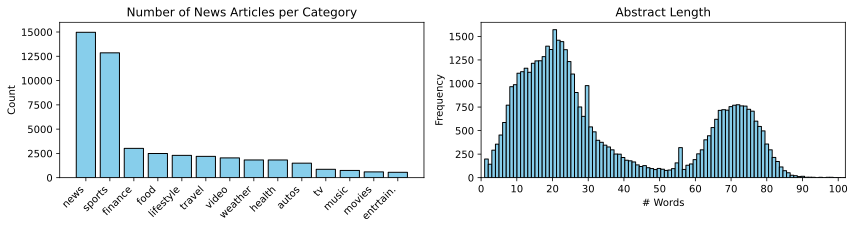

In [5]:
c = data['Category'].value_counts()
c = c[c >= 100]

c.index = c.index.where(c.index != 'foodanddrink', 'food')
c.index = c.index.where(c.index != 'entertainment', 'entrtain.')

# Plot the bar chart
plt.figure(figsize=(12, 3.3))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.bar(c.index, c.values, color='skyblue', edgecolor='black')
plt.ylabel('Count')
plt.title('Number of News Articles per Category')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylim(0, 16001)

# Plot the histogram
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.hist(abstract_word_counts, bins=470, color='skyblue', edgecolor='black')
plt.xlabel('# Words')
plt.ylabel('Frequency')
plt.title('Abstract Length')
plt.xticks(range(0, 101, 10))  # Set x-ticks
plt.xlim(0, 102)

plt.tight_layout()
plt.show()


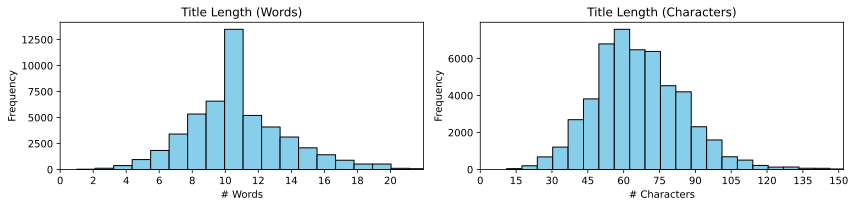

In [6]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Plot histogram for number of words
axes[0].hist(title_word_counts, bins=50, color='skyblue', edgecolor='black')
axes[0].set_xlabel('# Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Title Length (Words)')
axes[0].set_xticks(range(0, 21, 2))  # Set x-ticks
axes[0].set_xlim(0, 22)  # Limit x-axis up to 20

# Plot histogram for number of characters
axes[1].hist(title_lengths, bins=50, color='skyblue', edgecolor='black')
axes[1].set_xlabel('# Characters')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Title Length (Characters)')
axes[1].set_xticks(range(0, 151, 15))  # Set x-ticks
axes[1].set_xlim(0, 152)  # Limit x-axis up to 150

plt.tight_layout()
plt.show()

In [7]:
# DataFrame from the calculated values
summary_data = pd.DataFrame({
    'Metric': ['# New articles', '# Users', '# User behaviors', 'Unique Categories', 'Unique Subcategories', 'Average Title Length (Words)', 'Average Title Length (Characters)', 'Average Abstract Length (Words)'],
    'Value': [number_of_articles, no_of_users, no_of_behaviors, unique_categories, unique_subcategories, round(avg_title_words, 2), round(avg_title_len, 2), round(avg_abstract_len, 2)]
})

# Markdown table generator
from IPython.display import Markdown, display
display(Markdown(summary_data.to_markdown(index=False)))

| Metric                            |     Value |
|:----------------------------------|----------:|
| # New articles                    |  50434    |
| # Users                           |  50000    |
| # User behaviors                  | 156965    |
| Unique Categories                 |     17    |
| Unique Subcategories              |    263    |
| Average Title Length (Words)      |     10.78 |
| Average Title Length (Characters) |     66.37 |
| Average Abstract Length (Words)   |     36.29 |



The authors of the original article [MIND: A Large-scale Dataset for News Recommendation](https://aclanthology.org/2020.acl-main.331) (Wu et al., ACL 2020)  show that most (84.5%) of articles have survival time of less than two days.

### Proposal of algorithms

- **kNN** on categories, 17 clusters, 263 subclusters
- **TF-IDF**
- embeddings computed by TransE method in *entity_embdedding.vec* and *relation_embedding.vec*


### Naive baseline implementation

1. History => reccomended article (according to category/subcategory) - green column **article_id**
    - in = user_id
    - out = reccomended articles
2. Popular in last 24h - orange column **articled_id-0/1**


### Basic idea of evaluation